# Data Loading and Initial Exploration

In [12]:
# Import necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv')
df.head()

,CountyFIPS,State,County,Region,Pct_renter_occupied,Distance_to_medsurge_icu,Pct_renter_cost_50pct_plus,Pct_renter_cost_30pct_plus,Total_population_poverty,Pct_owner_cost_30plus,...,Pct_age_65plus,Pct_homes_no_vehicle,Pct_public_transit,Pct_single_parent,Pct_hh_no_internet,Distance_to_ED,Pct_mobile_homes,Pct_disabled,Is_Metro_Micro,Bed_util_ratio
0,1001,Alabama,Autauga County,South,24.941176,5.352941,28.352941,43.176470,55181.0,19.588235,...,15.352941,5.294117,0.470588,27.411764,82.352941,5.294117,17.882352,17.470588,1.0,0.378106
1,1003,Alabama,Baldwin County,South,22.727272,7.500000,19.545454,43.795454,215170.0,20.227272,...,21.681818,3.090909,0.045454,20.386363,83.204545,6.409090,12.159090,13.977272,1.0,0.504948
2,1005,Alabama,Barbour County,South,37.888888,8.666666,20.666666,46.222222,22070.0,16.333333,...,19.777777,11.888888,0.111111,47.777777,65.000000,8.666666,27.888888,19.111111,1.0,0.284690
3,1007,Alabama,Bibb County,South,24.500000,21.250000,27.750000,49.625000,20748.0,13.250000,...,16.250000,5.750000,0.000000,31.750000,74.875000,8.500000,33.250000,18.000000,1.0,0.286999
4,1009,Alabama,Blount County,South,24.062500,9.750000,23.562500,47.875000,57127.0,15.187500,...,18.500000,5.375000,0.125000,26.062500,80.187500,9.625000,25.500000,15.000000,1.0,0.304907


# Preprocessing, Encoding, Imputation

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop

# --- 1. Load and Initial Cleaning ---
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

# Drop unnecessary columns
df_cleaned = df_cleaned.drop(columns=["State", "Land_area_sqmi", "Pct_renter_cost_30pct_plus"], errors="ignore")

# Drop rows with missing predictor values (except for Is_Metro_Micro and Bed_util_ratio)
predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# --- 2. Split modeling vs missing target ---
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# --- 3. Train-Test Split ---
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]

split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# --- 4. Encoding ---
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)

# Align columns between train and test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County"], errors="ignore")
X_test = X_test.drop(columns=["CountyFIPS", "County"], errors="ignore")

# --- 5. Scaling and Imputation ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# --- 6. Reattach Targets ---
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# --- 7. Handle missing-target dataset ---
df_missing_target_encoded = df_missing_target.copy()

df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)

df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

df_missing_scaled = df_missing_target_encoded.copy()
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)

df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# --- 8. Combine Full Dataset ---
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# --- 9. Export ---
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


Modeling dataset shape (non-missing target): (2391, 21)
Rows with missing Bed_util_ratio preserved separately: (751, 21)

Calculated train/test split: 0.78/0.22

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.425206                 -0.471017                    1.383843   
1            -0.699455                 -0.248219                    0.014196   
2             1.178700                 -0.127155                    0.188555   
3            -0.479857                  1.178608                    1.290080   
4            -0.534053                 -0.014738                    0.638884   

   Total_population_poverty  Pct_owner_cost_30plus  Population_density  \
0                 -0.184447               0.243717           -0.032985   
1                  0.265340               0.379438           -0.254184   
2                 -0.277534              -0.447575  

## Hyperparameter Tuning & Other Model Tuning

In [14]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from scipy.special import inv_boxcox

def evaluate_and_plot(model, X_train, X_test, y_train, y_test, model_name="Model", lambda_bc=None):
    """
    Evaluates a regression model, prints performance metrics, and generates diagnostic plots.
    Optionally handles Box-Cox transformation for predictions and true values.

    Args:
        model: Trained regression model.
        X_train: Training features.
        X_test: Testing features.
        y_train: Training target variable (original scale or Box-Cox).
        y_test: Testing target variable (original scale or Box-Cox).
        model_name: Label for printed metrics and plots.
        lambda_bc: Lambda value used for Box-Cox transformation. If provided,
                   will inverse-transform both predictions and targets.

    Returns:
        None. Prints metrics and shows residual and prediction plots.
    """
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Optional: Inverse Box-Cox transform to original scale
    if lambda_bc is not None:
        epsilon = 1e-6  # Small positive value for numerical stability

        # Clip both predictions AND true values for numerical stability
        y_train_pred = np.clip(y_train_pred, epsilon, None)
        y_test_pred = np.clip(y_test_pred, epsilon, None)
        y_train = np.clip(y_train, epsilon, None)
        y_test = np.clip(y_test, epsilon, None)

        # Debug: show predictions before inverse
        print("\nBefore Inverse Box-Cox")
        print("Predicted (Box-Cox):", y_test_pred[:5])
        print("Actual (Box-Cox):   ", y_test[:5])

        # Inverse Box-Cox (predictions and targets)
        y_train_pred = inv_boxcox(y_train_pred, lambda_bc)
        y_test_pred = inv_boxcox(y_test_pred, lambda_bc)
        y_train = inv_boxcox(y_train, lambda_bc)
        y_test = inv_boxcox(y_test, lambda_bc)

        # Debug: show predictions after inverse
        print("\nAfter Inverse Box-Cox")
        print("Predicted (Original):", y_test_pred[:5])
        print("Actual (Original):   ", y_test[:5])


    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"\n{model_name} Performance:")
    print(f"Train RMSE: {train_rmse:.4f} | R²: {train_r2:.4f} | MAE: {train_mae:.4f}")
    print(f"Test  RMSE: {test_rmse:.4f} | R²: {test_r2:.4f} | MAE: {test_mae:.4f}")

    # Residuals
    residuals = y_test - y_test_pred

    # Diagnostic plots
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_test_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'Predicted vs Actual Utilization Ratio')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f'Residual Distribution Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title(f'{model_name} Residuals vs Predicted')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# XGBoost Regressor (with GridSearchCV - No PCA)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
XGBoost Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

XGBoost Regression Performance:
Train RMSE: 0.1163 | R²: 0.4956 | MAE: 0.0917
Test  RMSE: 0.1378 | R²: 0.3617 | MAE: 0.1057


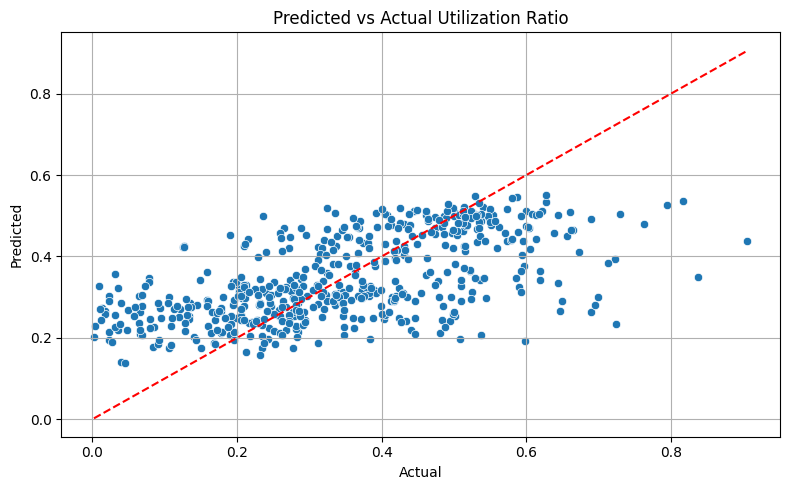

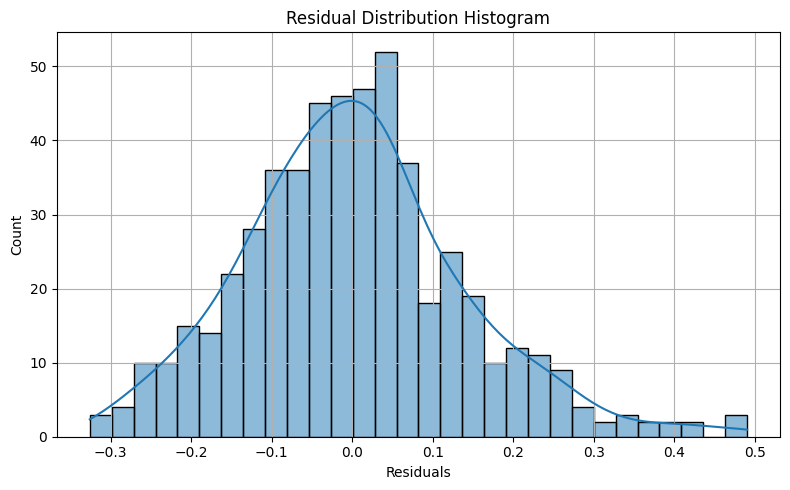

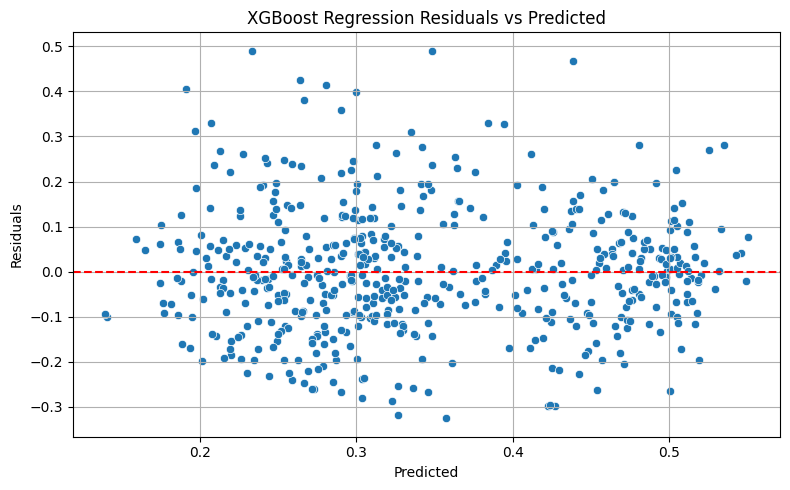

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
"""
Performs hyperparameter tuning for XGBoost Regression using GridSearchCV
and evaluates the best model.

The XGBoost Regressor is tuned over the following hyperparameters:
- 'learning_rate': [0.05, 0.1] (learning rate for the boosting process)
- 'n_estimators': [100, 200] (Number of gradient boosted trees)
- 'max_depth': [3, 5] (maximum depth of trees for base learners)

GridSearchCV uses the specified cross-validation strategy (`cv_strategy`) and
neg_mean_squared_error as the scoring metric to find the optimal combination
of hyperparameters. A fixed `random_state` is used for reproducibility.

After fitting the GridSearchCV object, the best estimator is retrieved,
its best parameters are printed, and the `evaluate_and_plot` function is
called to assess its performance on the scaled training and testing data,
generating relevant evaluation metrics and diagnostic plots.
"""
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import KFold

# Define cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)


# XGBoost Tuning
xgb_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}

xgb_grid = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    xgb_params, cv=cv_strategy, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)
xgb_grid.fit(X_train_scaled, y_train)

# XGBoost Evaluation
xgb_best = xgb_grid.best_estimator_
print("XGBoost Best Params:", xgb_grid.best_params_)
evaluate_and_plot(xgb_best, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost Regression")

xgb_best = xgb_grid.best_estimator_
xgb_best


# Diagnostic Plot and Residual Analysis by Region


               mean       std  count
Region                              
West      -0.009862  0.151498     85
Midwest   -0.009393  0.127180    172
South      0.009455  0.142630    212
Northeast  0.023838  0.128410     58


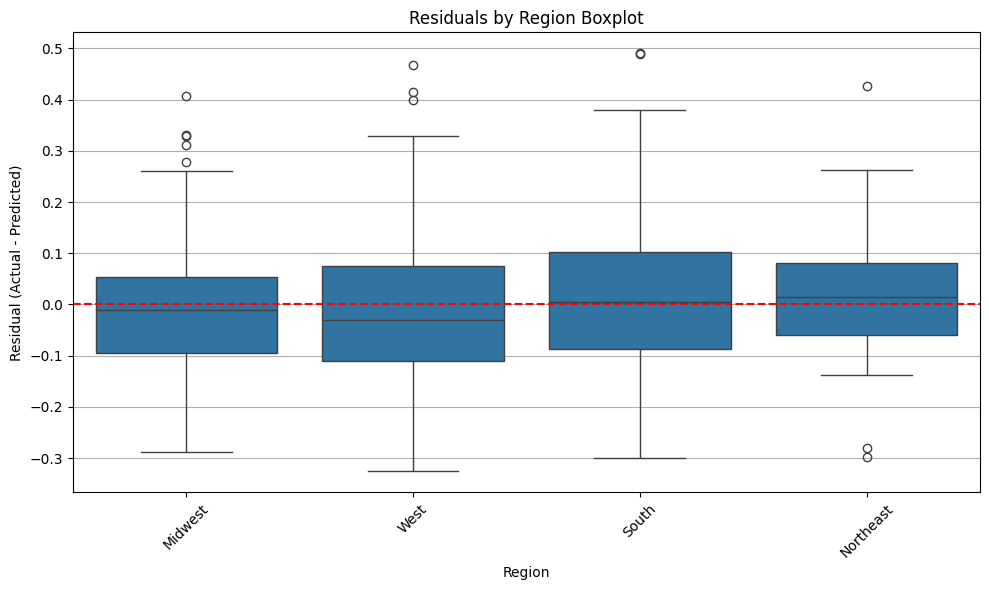

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Recalculate predictions for the test set using the final XGBoost model
y_test_pred = xgb_best.predict(X_test_scaled)

# Calculate residuals
residuals = y_test - y_test_pred

# Retrieve Region info from original df_modeling using test set index
region_test = df_modeling.loc[y_test.index, "Region"]

# Combine into a DataFrame for analysis
residuals_df = pd.DataFrame({
    "Region": region_test,
    "Residual": residuals
})

# Summary table of residuals by Region
region_summary = residuals_df.groupby("Region")["Residual"].agg(["mean", "std", "count"]).sort_values("mean")
print(region_summary)

# Plot residuals by Region (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Region", y="Residual", data=residuals_df)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals by Region Boxplot")
plt.ylabel("Residual (Actual - Predicted)")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
